In [ ]:
#pip install tensorflow[and-cuda]

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
import pandas as pd
import random
import keras
from keras import regularizers

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [47]:
# Define constants
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 10
epochs = 200

In [49]:
def CNN():
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [50]:
def CNN_dropout(value):
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(value),
    layers.Dense(num_classes, activation='softmax')])

In [51]:
def CNN_regulatization(value):
    return models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, kernel_regularizer=regularizers.L2(value), activation='relu'),
    layers.Dense(num_classes, activation='softmax')])

In [52]:
def residual_block(x, filters, kernel_size=3, strides=1):
    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    # Skip connection
    if strides > 1:
        x = layers.Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    out = layers.Add()([x, y])
    out = layers.Activation('relu')(out)
    return out

def ResNet18():
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=2, padding='same')(x)

    # Residual blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, strides=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, strides=2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    return model

In [53]:
class TestCase:
    def __init__(self, name, train_datagen, test_datagen, model):
        self.name = name
        self.train_datagen = train_datagen
        self.test_datagen = test_datagen
        self.model = model

    def Test(self, batch_size = 64):
        random.seed(1)
        keras.utils.set_random_seed(1)
        
        train_generator = self.train_datagen.flow_from_directory(
            'data/train',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
            )   

        test_generator = self.test_datagen.flow_from_directory(
            'data/test',
            target_size=image_size,
            batch_size=batch_size,
            class_mode='categorical'
        )
        
        self.model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=test_generator,
        )
        
        hist_df = pd.DataFrame(self.history.history) 
        hist_df.to_csv(f"{self.name}.csv")
        
    

In [54]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

test1 = TestCase("CNN_na_czysto", train_datagen, test_datagen, CNN())
test1.Test()

test2 = TestCase("CNN_dropout_0_3", train_datagen, test_datagen, CNN_dropout(0.3))
test2.Test()

test3 = TestCase("CNN_regulatization_0.1", train_datagen, test_datagen, CNN_regulatization(0.1))
test3.Test()

Found 90000 images belonging to 10 classes.
Found 90000 images belonging to 10 classes.
Epoch 1/200
1407/1407 [==============================] - 88s 62ms/step - loss: 1.5480 - accuracy: 0.4282 - val_loss: 1.3987 - val_accuracy: 0.5027
Epoch 2/200
1407/1407 [==============================] - 86s 61ms/step - loss: 1.2294 - accuracy: 0.5552 - val_loss: 1.2245 - val_accuracy: 0.5554
Epoch 3/200
1407/1407 [==============================] - 86s 61ms/step - loss: 1.0913 - accuracy: 0.6067 - val_loss: 1.1061 - val_accuracy: 0.6013
Epoch 4/200
1407/1407 [==============================] - 86s 61ms/step - loss: 0.9838 - accuracy: 0.6466 - val_loss: 1.0969 - val_accuracy: 0.6088
Epoch 5/200
1407/1407 [==============================] - 88s 63ms/step - loss: 0.8942 - accuracy: 0.6791 - val_loss: 1.0912 - val_accuracy: 0.6215
Epoch 6/200
 669/1407 [=============>................] - ETA: 30s - loss: 0.7944 - accuracy: 0.7152

In [ ]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9,1.1],
    fill_mode='nearest'
)


1/1 [==============================] - 0s 17ms/step


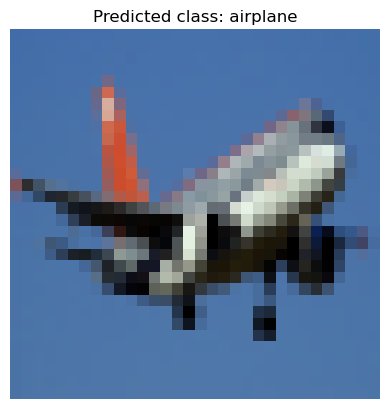

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image

# Get a random image from the test set
#random_class = 'plane'
#random_image_path = os.path.join('data/test', random_class)
random_image_files = os.listdir('data/test')
random_image_file = np.random.choice(random_image_files)
random_image = image.load_img(os.path.join('data/test', random_image_file), target_size=image_size)
random_image_array = image.img_to_array(random_image)
random_image_array = np.expand_dims(random_image_array, axis=0) / 255.0  # Rescale to [0,1]

# Predict the class of the random image
predictions = model.predict(random_image_array)
predicted_class_index = np.argmax(predictions)
predicted_class = list(train_generator.class_indices.keys())[predicted_class_index]

# Display the image and its predicted class
plt.imshow(random_image)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()


## inne

In [20]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import pathlib
import cv2
import os
from os import listdir
import glob
from PIL import Image

cinic_directory_train = './data/train'
cinic_directory_test = './data/test'

class_name = []
file_name='output_fromKeras.csv'
optimiser='adamax' # les best : Adam, nadam et adamax
nb_epochs=50
batch_size_choice=16
image_size=(32, 32)
loss_func='sparse_categorical_crossentropy'

In [21]:
# loading in the data 
train_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_choice
)

Found 90000 files belonging to 10 classes.
Using 72000 files for training.


In [22]:
# loading in the data 
validation_ds = keras.preprocessing.image_dataset_from_directory(
    cinic_directory_train,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_choice
)

Found 90000 files belonging to 10 classes.
Using 18000 files for validation.


In [23]:
class_names= train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [24]:
def make_model_keras2(input_shape, num_classes):
    # Build the model using the functional API
    # input layer
    i = keras.Input(shape=input_shape)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.2)(x)

    # Hidden layer
    x = keras.layers.Dense(1024, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)

    # last hidden layer i.e.. output layer
    x = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(i, x)

In [25]:
model = make_model_keras2(input_shape=(32,32, 3), num_classes=10)

model.compile(
    optimizer=optimiser,  #Fonction d'optimisation    
    loss=loss_func, #voir la doc de tensorflow "losses"
    metrics=['accuracy']
)

In [26]:
resultFile = []

total = 0
list = os.scandir(cinic_directory_test)
for testPicture in list:
    image_to_predict = cv2.imread(testPicture.path, cv2.IMREAD_COLOR)
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict, (32, 32)), axis=0)
    
    #prediction
    res = np.argmax(model.predict(img_to_predict), axis=-1)
    resultFile.append(testPicture.name + ',' + class_names[res[0]])
    
    total += 1
    print("Total images : " + str(total), end='\r')
    # print(resultFile)
    
    
    
f = open(file_name, 'w')
f.write('filename,label')
f.write('\n')
for resultLine in resultFile:
    f.write(resultLine)
    f.write('\n')
f.close()

1/1 [==============================] - 0s 65ms/step
